# Collaborative structural biology using machine learning and Jupyter notebook
##    Fergus Boyles and Fergus Imrie
##    *Department of Statistics, University of Oxford*

# Protein sequence comparison using machine learning

The data set consists of 13,710 proteins, belonging to 4,535 distinct folds, with a sequence identity of 40% or less. The data are drawn from the 06.02.2016 build of the ASTRAL database.

The data set consists of pairs of proteins for which both proteins belong to the same family, superfamily, or fold. Putative negative examples are generated for each protein by randomly selecting twenty other proteins that do not belong to the same family, superfamily, or fold.

For each pair of proteins we have been provided with a set of eight computed features, such as sequence length, predicted contacts, and sequence identity. Our challenge is, given a protein target and set of template proteins, can we predict which of those templates belong to the same family, superfamily, or fold as the target protein?

The data set is split into four disjoint clusters. 

1 - proteins that are in the same SCOP family as at least one other protein<br>
2 - proteins that are not in the same SCOP family, but are in the same superfamily as at least one other protein<br>
3 - proteins that are not in the same SCOP family or superfamily, but share the same fold as at least one other protein<br>
4 - proteins that do not belong to the same fold as any other protein in the data set<br>

Most proteins fall into the first cluster, so we're going to use this portion of the data for the rest of this notebook.<br>

# A Python environment for data science

* numpy: Matrix algebra and numerical methods.
* pandas: Data frames for manipulating and visualising data as tables.
* matplotlib: Everybody's favourite Python plotting library.
* seaborn: Statistical visualisation library built on matplotlib and pandas. Lots of high-level functions for data visualisation.
* scikit-learn (sklearn): Machine learning library. Today we'll use its implementations of logistic regression and random forest.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

sns.set(context='notebook', style='white', font_scale=1.8)

To keep this notebook as short and tidy as possible, I've written some helper functions for thinks like plotting and data processing. Check out the other files if you'd like to see how things are implemented.

In [3]:
import halp, pls

# Data exploration with Pandas and Seaborn

_Load and look:_ Can directly load data from csv using pandas. Don't forget to look at your data!

In [4]:
all_data = pd.read_csv('../data/Data_3DSig.txt', sep=' ')
all_data.dropna(axis='index', how='any', inplace=True)
all_data.head()

,Target,Template,Target_Length,Template_Length,Contact_PPV,Contact_TP,Contact_P,Contact_All,Neff,SeqID,Label
0,d12asa_,d1yfsa2,328,237,4.65,2,43,101,2676,0.177,Fam
1,d12asa_,d1eova2,328,354,22.99,20,87,101,2676,0.223,Fam
2,d12asa_,d1b8aa2,328,336,22.22,20,90,101,2676,0.220,Fam
3,d12asa_,d1l0wa3,328,357,20.00,17,85,101,2676,0.235,Fam
4,d12asa_,d1z7ma1,328,312,1.27,1,79,101,2676,0.211,Fam


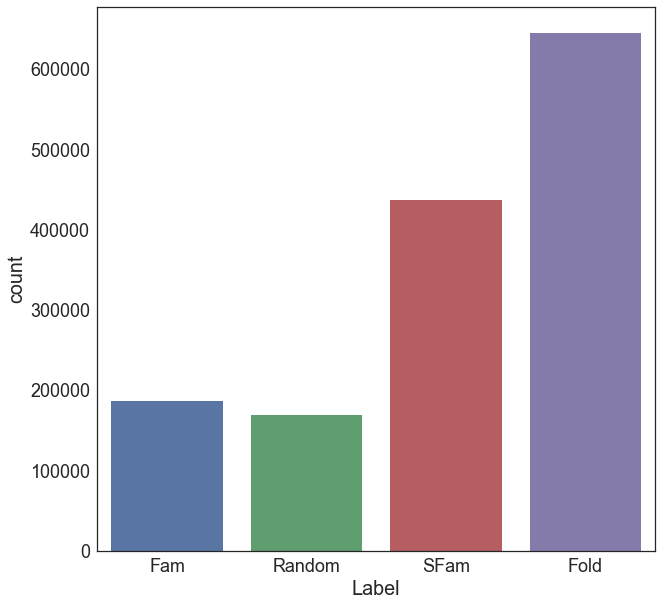

In [5]:
split = pd.read_csv('../data/Data_Split.txt', sep=' ', header=None)
split.columns = ['Protein', 'Split']

# Select target-template pairs where both proteins belong to the 'same family' cluster
targets = split[split['Split']=='FAMILY']['Protein']
data = all_data[(all_data['Target'].isin(targets)) & (all_data['Template'].isin(targets))].copy()

# Drop duplicated rows since we don't know which entry is correct
# Be sure to keep a record of which samples are dropped
duplicate_idx = data.duplicated(subset=['Template', 'Target'], keep=False)
duplicates = data.loc[duplicate_idx].sort_values(by=['Target', 'Template'])
data.drop_duplicates(subset=['Template', 'Target'], keep=False, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.countplot(data=data, x='Label', ax=ax)

# The 'easy' problem: 'same family' vs 'random' classification

Can we predict, given the features, whether the target and template protein are from the same protein family?

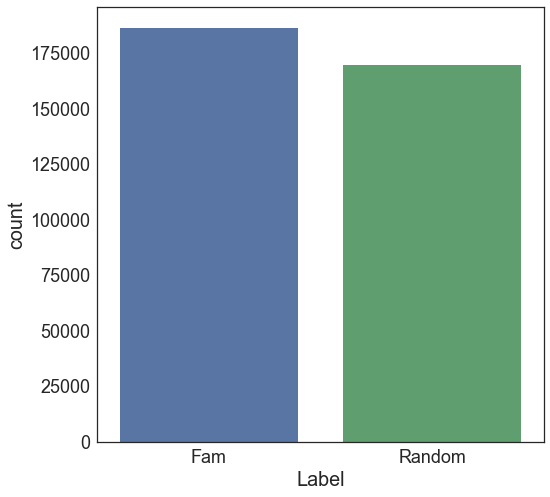

In [25]:
family_data = data[data['Label'].isin(['Fam', 'Random'])].copy()

fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.countplot(data=family_data, x='Label', ax=ax)

Data is balanced so don't need to worry about any imbalance.

Important that we decide train/validation/test sets before we go any further. We adopt a 80/10/10 split. Note below that we sample a subset (5000) of the total number of proteins (10251). Also note that we're splitting *by target* rather than simply splitting the examples. This ensures that all examples for a target are in the same set.

Also, for reproducibility, we set the seed for our random number generator.

In [7]:
np.random.seed(42)
n_samples = 5000

sample = np.random.choice(family_data['Target'].unique(), size=n_samples, replace=False)

n_train = int(0.8*n_samples)
n_test = int(0.2*n_samples)

train = sample[:n_train]
test = sample[n_train:]

In [8]:
feature_names = ['Target_Length', 'Template_Length', 'Contact_PPV', 'Contact_TP', 'Contact_P', 'Contact_All', 'Neff', 'SeqID']

train_idx = family_data['Target'].isin(train)
test_idx = family_data['Target'].isin(test)

X_train = family_data[train_idx][feature_names].values
X_test = family_data[test_idx][feature_names].values

y_train = family_data[train_idx]['Label'].replace({'Random': 0, 'Fam': 1}).values
y_test = family_data[test_idx]['Label'].replace({'Random': 0, 'Fam': 1}).values

Confirm that our training, validation, and test sets all have a similar balance of positive and negative examples.

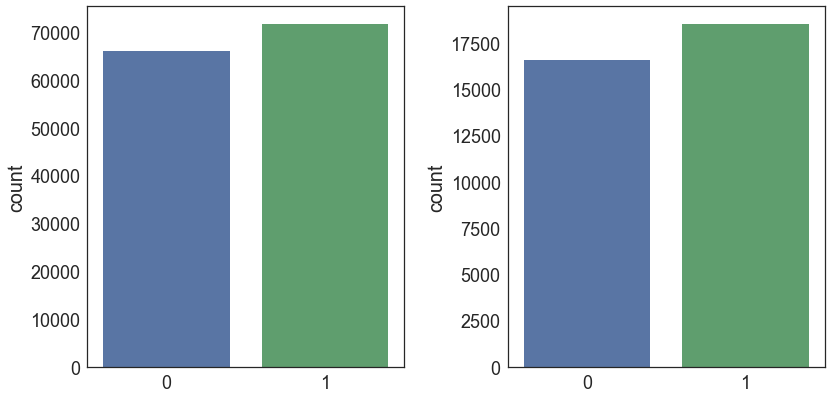

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x=y_train, ax=axes[0])
sns.countplot(x=y_test, ax=axes[1])
fig.tight_layout()

In [19]:
#classifier = LogisticRegression(C=1e5, random_state=42)
classifier = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [20]:
print(f'Accuracy score: {classifier.score(X_test, y_test):.3f}')

Accuracy score: 0.880


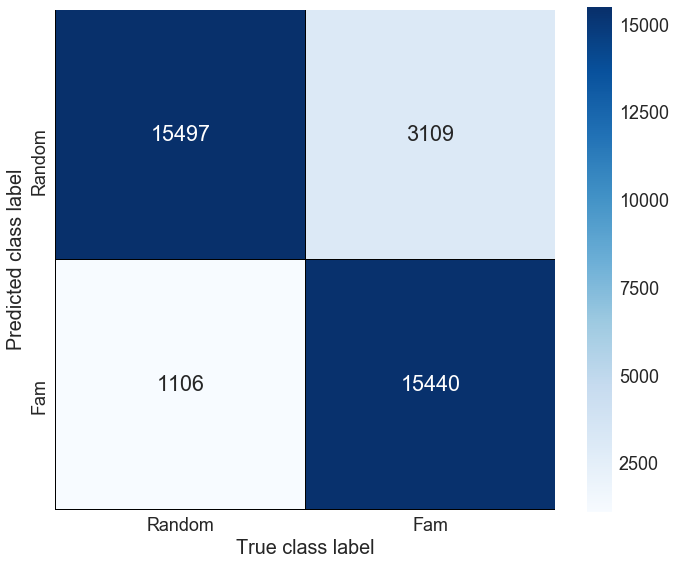

In [21]:
predicted = classifier.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 10))
halp.draw_confusion_matrix(y_test, predicted, ['Random', 'Fam'], ax=ax)
fig.tight_layout()

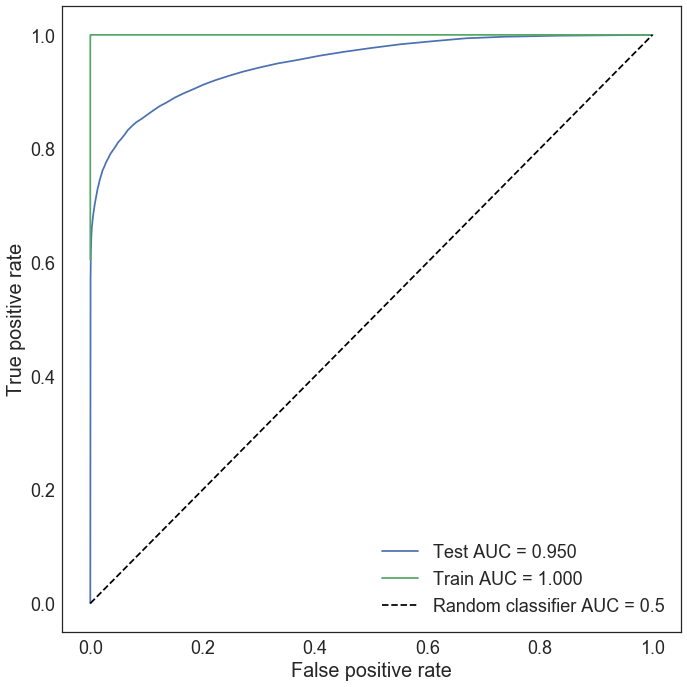

In [24]:
class_probs = classifier.predict_proba(X_test)[:,1]

fig, ax = plt.subplots(figsize=(10, 10))
halp.draw_roc_curve(y_test, class_probs, name='RF Test', ax=ax)

class_probs = classifier.predict_proba(X_train)[:,1]
halp.draw_roc_curve(y_train, class_probs, name='RF Train', ax=ax)

ax.plot([0,1],[0,1], 'k--', label='Random classifier AUC = 0.5')
ax.legend(loc='best')
fig.tight_layout()